**Data Loading And Inital Exploration**



In [1]:
import pandas as pd
import numpy as np

In [3]:
#loading data
df=pd.read_csv(r"/content/Uber Request Data.csv",delimiter=',')

In [4]:
#check first 5
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


**Data Preprocessing**

In [ ]:
#uniform date time format
#df['Drop timestamp']=pd.to_datetime(df['Drop timestamp'], format='mixed')
#df['Drop timestamp']=df['Drop timestamp'].dt.strftime('%d-%m-%Y %H:%M:%S')
#df['Request timestamp']=pd.to_datetime(df['Request timestamp'], format='mixed')
#df['Request timestamp']=df['Request timestamp'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [5]:
#check for duplicates
df.duplicated().unique()

array([False])

there's no duplicate rows

In [6]:
#check for inconsitent formatting in strings
df['Pickup point'].value_counts()

,count
Pickup point,
City,3507
Airport,3238


In [7]:
df['Status'].value_counts()

,count
Status,
Trip Completed,2831
No Cars Available,2650
Cancelled,1264


no inconsistencies

In [8]:
#make sure no integers are stored as objects/strings
print(df.select_dtypes(include='object').columns)

Index(['Pickup point', 'Status', 'Request timestamp', 'Drop timestamp'], dtype='object')


In [9]:
#check for nulls
print(df.isnull().sum())

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64


In [10]:
#check the number of missing cells
totalCells=df.size
missingCells=df.isnull().sum().sum()
print("total cells ", totalCells)
print("missing cells", missingCells)
print("percentage= ",(missingCells/totalCells)*100)

total cells  40470
missing cells 6564
percentage=  16.219421793921423


In [11]:
#chech what columns have nulls in each status
df[df['Status']=='Trip Completed'].isnull().sum()

,0
Request id,0
Pickup point,0
Driver id,0
Status,0
Request timestamp,0
Drop timestamp,0


In [13]:
df[df['Status']=='Cancelled'].isnull().sum()

,0
Request id,0
Pickup point,0
Driver id,0
Status,0
Request timestamp,0
Drop timestamp,1264


since the trip is cancelled it's logical to be no drop time and date

In [14]:
df[df['Status']=='No Cars Available'].isnull().sum()

,0
Request id,0
Pickup point,0
Driver id,2650
Status,0
Request timestamp,0
Drop timestamp,2650


it's also logical there's no driver or drop time and date

In [15]:
#create new data frame for each status
completed=df[df['Status']=='Trip Completed'].copy()
cancelled=df[df['Status']=='Cancelled'].copy()
carsUnaivalable=df[df['Status']=='No Cars Available'].copy()

In [16]:
#delete columns that are not applicable in each data frame
#axis=1 to drop columns
#how='all' to only drop columns are completely null which in our case are all columns that contain nulls
cancelled=cancelled.dropna(axis=1,how='all')
cancelled.isnull().sum()

,0
Request id,0
Pickup point,0
Driver id,0
Status,0
Request timestamp,0


In [17]:
carsUnaivalable=carsUnaivalable.dropna(axis=1,how='all')
carsUnaivalable.isnull().sum()

,0
Request id,0
Pickup point,0
Status,0
Request timestamp,0


In [18]:
#uniform date time format
completed['Drop timestamp']=pd.to_datetime(completed['Drop timestamp'],dayfirst=True, format='mixed')
completed['Request timestamp']=pd.to_datetime(completed['Request timestamp'],dayfirst=True, format='mixed')


cancelled['Request timestamp']=pd.to_datetime(cancelled['Request timestamp'],dayfirst=True, format='mixed')


carsUnaivalable['Request timestamp']=pd.to_datetime(carsUnaivalable['Request timestamp'],dayfirst=True, format='mixed')

In [19]:
completed.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


**Feature Engineering**

In [20]:
# function to get time slot
def time_slot(hour):
    if pd.isnull(hour):
        return None
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

#features for request timestamps for completed rides
completed['Requested hours']=completed['Request timestamp'].dt.hour+completed['Request timestamp'].dt.minute/60
#completed['Requested mins']=completed['Request timestamp'].dt.minute
completed['Requested day']=completed['Request timestamp'].dt.day
completed['Requested dayofweek']=completed['Request timestamp'].dt.day_name()
completed['Requested month']=completed['Request timestamp'].dt.month
completed['Request TimeSlot'] = completed['Requested hours'].apply(time_slot)

#features for drop timestamps for completed rides
completed['drop hours']=completed['Drop timestamp'].dt.hour+completed['Drop timestamp'].dt.minute/60
#completed['drop mins']=completed['Drop timestamp'].dt.minute
completed['drop day']=completed['Drop timestamp'].dt.day
completed['drop dayofweek']=completed['Drop timestamp'].dt.day_name()
completed['drop month']=completed['Drop timestamp'].dt.month
completed['drop TimeSlot'] = completed['drop hours'].apply(time_slot)

#time duration in minutes for completed rides
completed['Trip duration']=(completed['Drop timestamp']-completed['Request timestamp']).dt.total_seconds()/60

#features for request timestamps for cancelled rides
cancelled['Requested hours']=cancelled['Request timestamp'].dt.hour+cancelled['Request timestamp'].dt.minute/60
#cancelled['Requested mins']=cancelled['Request timestamp'].dt.minute
cancelled['Requested day']=cancelled['Request timestamp'].dt.day
cancelled['Requested dayofweek']=cancelled['Request timestamp'].dt.day_name()
cancelled['Requested month']=cancelled['Request timestamp'].dt.month
cancelled['Request TimeSlot'] = cancelled['Requested hours'].apply(time_slot)

#features for request timestamps for cancelled rides
carsUnaivalable['Requested hours']=carsUnaivalable['Request timestamp'].dt.hour+carsUnaivalable['Request timestamp'].dt.minute/60
#carsUnaivalable['Requested mins']=carsUnaivalable['Request timestamp'].dt.minute
carsUnaivalable['Requested day']=carsUnaivalable['Request timestamp'].dt.day
carsUnaivalable['Requested dayofweek']=carsUnaivalable['Request timestamp'].dt.day_name()
carsUnaivalable['Requested month']=carsUnaivalable['Request timestamp'].dt.month
carsUnaivalable['Request TimeSlot'] = carsUnaivalable['Requested hours'].apply(time_slot)

**Data Visualization**

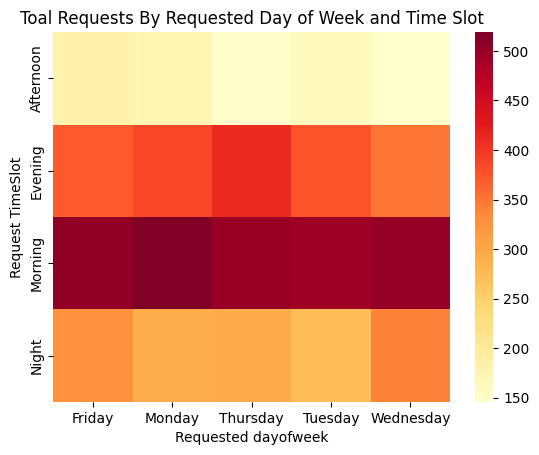

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_requests = pd.concat([completed, cancelled, carsUnaivalable])
heatmap_data = all_requests.groupby(['Requested dayofweek', 'Request TimeSlot']).size().reset_index(name='count')
pivot_table = heatmap_data.pivot( columns='Requested dayofweek',index='Request TimeSlot', values="count")

sns.heatmap(pivot_table, cmap="YlOrRd")
plt.title("Toal Requests By Requested Day of Week and Time Slot")
plt.show()

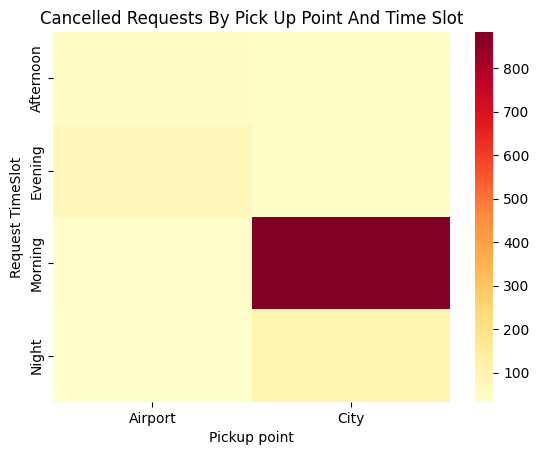

In [ ]:
#all_requests = pd.concat([completed, cancelled, carsUnaivalable])
heatmap_data = cancelled.groupby(['Pickup point', 'Request TimeSlot']).size().reset_index(name='count')
pivot_table = heatmap_data.pivot( columns='Pickup point',index='Request TimeSlot', values="count")

sns.heatmap(pivot_table, cmap="YlOrRd")
plt.title("Cancelled Requests By Pick Up Point And Time Slot")
plt.show()

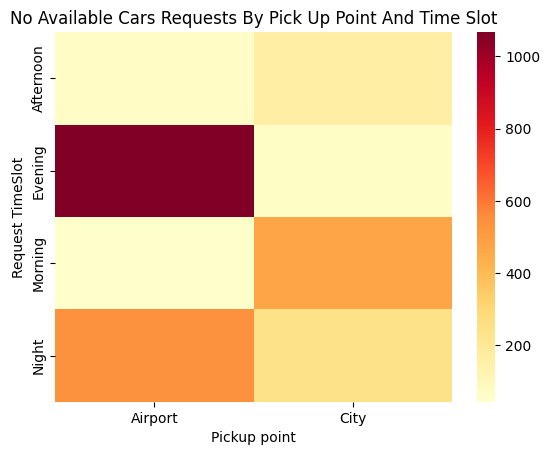

In [ ]:
#all_requests = pd.concat([completed, cancelled, carsUnaivalable])
heatmap_data = carsUnaivalable.groupby(['Pickup point', 'Request TimeSlot']).size().reset_index(name='count')
pivot_table = heatmap_data.pivot( columns='Pickup point',index='Request TimeSlot', values="count")

sns.heatmap(pivot_table, cmap="YlOrRd")
plt.title("No Available Cars Requests By Pick Up Point And Time Slot")
plt.show()

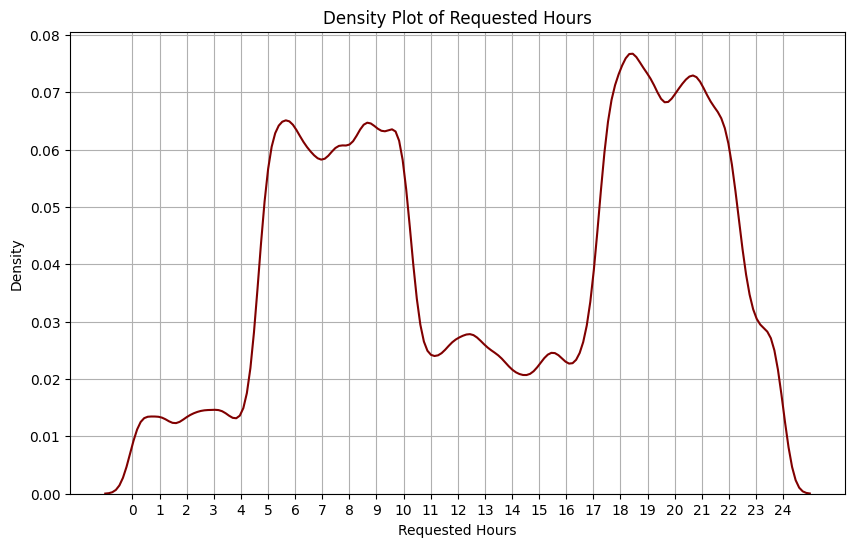

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(all_requests['Requested hours'],bw_adjust=0.3, color='maroon' ,fill=False)
plt.xticks(np.arange(0,25,1))
plt.title("Density Plot of Requested Hours")
plt.xlabel("Requested Hours")
plt.ylabel("Density")
plt.grid(True)
plt.show()

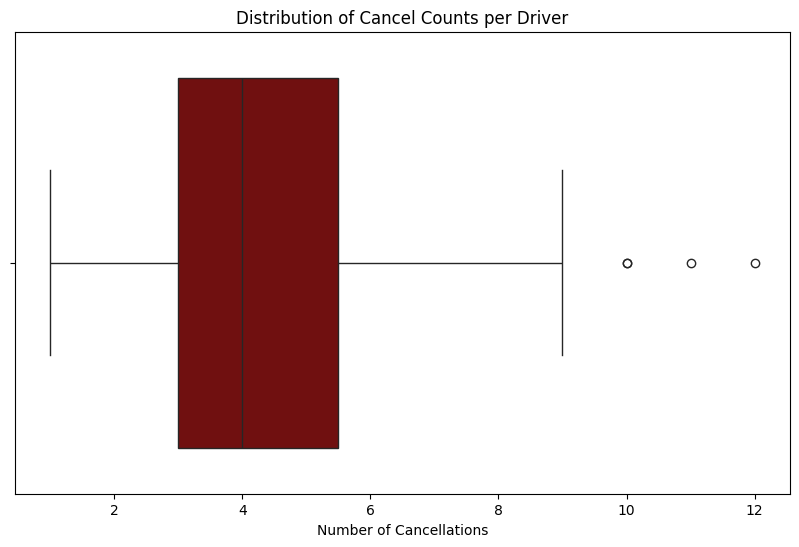

In [ ]:
cancel_counts = cancelled.groupby('Driver id').size().reset_index(name='Cancel Count')
plt.figure(figsize=(10, 6))
sns.boxplot(x=cancel_counts['Cancel Count'],color='maroon')
plt.title('Distribution of Cancel Counts per Driver')
plt.xlabel('Number of Cancellations')
plt.show()

In [ ]:
#all the drivers that exceed the upper bound of cancellations
cancel_counts[cancel_counts['Cancel Count'] > 9]

,Driver id,Cancel Count
50,54.0,11
78,84.0,12
136,142.0,10
200,206.0,10


In [ ]:
#drivers that completed the most rides
completed.groupby('Driver id').size().reset_index(name='Completed Count').sort_values(by='Completed Count', ascending=False).head(3)

,Driver id,Completed Count
21,22.0,16
232,233.0,15
183,184.0,15


**Machine learning**

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

 # Merge them into one dataframe to benefit from the features
df_encoded = pd.concat([completed, cancelled, carsUnaivalable], ignore_index=True)

# Shuffle the rows
df_encoded = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode all string columns
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != "Status":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

X = df_encoded.drop(columns=["Status", "Request timestamp", "Drop timestamp"]).dropna(axis=1)
y = df_encoded["Status"]

# Split to training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Decision Tree Classifier

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8910303928836175
                   precision    recall  f1-score   support

        Cancelled       0.69      0.77      0.73       258
No Cars Available       0.88      0.83      0.86       533
   Trip Completed       1.00      1.00      1.00       558

         accuracy                           0.89      1349
        macro avg       0.86      0.87      0.86      1349
     weighted avg       0.90      0.89      0.89      1349

